<a href="https://colab.research.google.com/github/Git-Hub-Ran/Deep_Learning/blob/Dev/deep_learning_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep learning exercise :**

Digit recognizer https://www.kaggle.com/competitions/digit-recognizer/data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
#Set random seeds for reproducibility (Makes your experiments reproducible - same results every time you run.)
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(41)

In [3]:
#Delete existing files if exist:
!rm -f train.csv train.csv.1 test.csv test.csv.1

#loading the files :
!wget https://raw.githubusercontent.com/vardhan-siramdasu/Kaggle-Digit-Recognizer/main/data/train.csv
!wget https://raw.githubusercontent.com/vardhan-siramdasu/Kaggle-Digit-Recognizer/main/data/test.csv
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#looking at the data:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


--2025-11-17 12:13:15--  https://raw.githubusercontent.com/vardhan-siramdasu/Kaggle-Digit-Recognizer/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76733040 (73M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  73.18M   165MB/s    in 0.4s    

2025-11-17 12:13:16 (165 MB/s) - ‘train.csv’ saved [76733040/76733040]

--2025-11-17 12:13:16--  https://raw.githubusercontent.com/vardhan-siramdasu/Kaggle-Digit-Recognizer/main/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 **Prepare the data :**

In [4]:
# Using 'values' to flatten the data:
X_train = train.drop('label', axis=1).values.astype('float32') / 255.0
Y_train = train['label'].values
X_test = test.values.astype('float32') / 255.0

In [5]:
#Train Test Split:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2, random_state=41)

In [6]:
#Convert to PyTorch Tensors:
x_train = torch.FloatTensor(x_train)
x_val   = torch.FloatTensor(x_val)
x_test  = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_val   = torch.LongTensor(y_val)


**Training mini-batch with dataloaders:**

Instead of running the entire training set through the model at once (which is memory-intensive and time-consuming),
we divide the data into small chunks (mini-batches).
This improves training efficiency and also helps the model learn better.

In [7]:
batch_size = 128

train_dataset = TensorDataset(x_train,y_train) #Create TensorDatasets for training set
val_dataset = TensorDataset(x_val,y_val) #Create TensorDatasets for the validation set

# Create DataLoaders to automatically handle batching and shuffling:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# shuffle=True means data will be mixed every epoch to improve learning
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # shuffle=False because validation data doesn't need random order

**Define CNN model:**

In [8]:
class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__() #instantiate our nn.Module
        #convolution = a layer that looks for patterns in an image
        # First convolution block: input 1 channel (because the images are in grayscale) -> 32 channels ( we chose 32 because it is not too big for basic patterns)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #Conv2d = Convolution 2D layer. kernel_size=3 : it is 3 because 3 is small enough to capture small patterns (e.g. lines, corners)
        self.bn1 = nn.BatchNorm2d(32) #BatchNorm = A layer that stabilizes the outputs after conv, which speeds up training and helps the network learn better.

        # Second conv block (Learns more complex patterns, so we will have 64 channels now):
        # input 32 channels  (from conv1) -> 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        #Pooling reduces the size of the image but preserves the important patterns:
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces spatial dimensions by half

        # Fully connected layers after flattening
        # the sizes of the feature maps after each pooling layer: original imag is 28x28 -> pooling 1 divides the dimension in half: 14x14 -> pooling 2 divides the dimension in half: 7x7
        self.fc1 = nn.Linear(64*7*7, 128) #input features = 64 channels×7×7 pixels per channel
        self.fc2 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(0.3)  # Dropout before fully connected layers: Randomly turning off neurons during training to prevent overfitting and improve generalization.

    #The function that defines how data travels through the network:
    def forward(self, x):
        x = x.view(-1,1,28,28) #Transforms the tensor shape into a 2D image with one channel (grayscale). Reshape from (batch size,784) -> (batch,1,28,28)
        x = F.relu(self.bn1(self.conv1(x))) #conv1 -> 32
        x = self.pool(x) #Reduces the dimensions by half (28×28 -> 14×14)
        x = F.relu(self.bn2(self.conv2(x))) #conv2 -> 64
        x = self.pool(x) #Reduces the dimensions by half (14×14 -> 7×7)
        x = x.view(-1, 64*7*7)  # Flatten for FC layers: Converts all feature maps to a long vector
        x = F.relu(self.fc1(x)) #fc1 -> 128 neurons
        x = self.dropout(x) #Turns off 30% of neurons during training to prevent overfitting
        x = self.fc2(x)#fc2 -> 10 neurons (score for each digit 0–9)
        return x #Returns the score for each digit for each image in the batch

# Create model instance
model = DigitCNN()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss() #Creating an instance of the class CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001) #We want to optimize the loss after each iteration: Choose Adam optimizer and learning rate.


**Training loop with validation :**

In [9]:
num_epochs = 50  # Number of times the network passes over the entire dataset.

train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0 #We will keep the best accuracy so far, to keep the best model

# Early Stopping parameters:
patience = 15 # How many epochs to wait without improvement before stopping
no_improvement = 0 # Counter for consecutive epochs with no improvement
best_val_loss = float('inf') # Initialize the best validation loss to infinity

for epoch in range(num_epochs):

    # ----- Training phase -----

    model.train() #Tells PyTorch that the model is in training mode
    running_loss = 0.0

    for images, labels in train_loader: #Transfers all data in mini-batches
        optimizer.zero_grad() #Resets the gradients from the previous epoch
        predictions = model(images) #forward pass through the CNN
        loss = criterion(predictions, labels) #Calculates the CrossEntropyLoss
        loss.backward()#backpropagation, computes gradients
        optimizer.step() #updates the network parameters according to the gradients
        running_loss += loss.item() #Adds the loss value of the batch

    avg_train_loss = running_loss / len(train_loader) #Calculates the average loss for the entire epoch
    train_losses.append(avg_train_loss) #Adds to train_losses list for graphing/tracking

    # ----- Validation phase (no gradient computation needed) -----

    model.eval() # tells PyTorch that the model is in evaluation mode, not training
    val_loss = 0.0 #The sum of the loss over the entire validation set
    val_correct = 0 #Count how many examples predicted correctly.
    val_total = 0 #Number of all examples

    with torch.no_grad(): #No gradient calculation, so less memory usage
        for images, labels in val_loader: #forward pass on the validation set
            predictions = model(images)
            loss = criterion(predictions, labels)
            val_loss += loss.item()

            # torch.max is saying:
              # Find the largest value along axis 1 (the highest score for each sample),
              # and also return the index of that value (which are actually the number that the model predicts)
            _, predicted_labels = torch.max(predictions,1) #Gets the class with the highest probability
            val_total += labels.size(0)
            # Comparing predictions to actual values:
              #The condition predicted_labels == labels will creates a vector of True/False for each example
              #sum() sums up all the True (equal to 1), it counts how many predictions were correct.
            val_correct += (predicted_labels == labels).sum().item() #Count how many pictures were predicted correctly.

    avg_val_loss = val_loss / len(val_loader) #Average validation loss
    val_losses.append(avg_val_loss)
    accuracy = val_correct / val_total # accuracy validation
    val_accuracies.append(accuracy)

    # During validation in training loop:
    if accuracy > best_val_acc: #If the accuracy on validation is better than anything before:
        best_val_acc = accuracy #update the validation accuracy

    # Early Stopping check : Check if current epoch's validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss # Update the best validation loss
        no_improvement = 0 # Reset the counter because we improved
        torch.save({ # Save best model automatically ased on Validation Loss
            'epoch': epoch,
            'model_state_dict': model.state_dict(), #Save the model state
            'optimizer_state_dict': optimizer.state_dict(), #Save the optimizer state
            'val_acc': accuracy,
        }, 'best_digit_cnn_model.pth')
        print(f"New best model saved with accuracy: {accuracy:.4f}")
    else:
        no_improvement += 1 # Increment the counter since no improvement occurred
        print(f"No improvement in val loss for {no_improvement} epoch(s)")

    if no_improvement >= patience:# If no improvement for 'patience' consecutive epochs, stop training
        print(f"Early stopping triggered at epoch {epoch}")
        break # Exit the training loop

#Displays status every 5 epochs:
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={accuracy:.4f}") #Shows real-time feedback on the training progress


New best model saved with accuracy: 0.9750
Epoch 0: Train Loss=0.2208, Val Loss=0.0767, Val Acc=0.9750
New best model saved with accuracy: 0.9848
New best model saved with accuracy: 0.9845
No improvement in val loss for 1 epoch(s)
No improvement in val loss for 2 epoch(s)
No improvement in val loss for 3 epoch(s)
Epoch 5: Train Loss=0.0324, Val Loss=0.0505, Val Acc=0.9851
New best model saved with accuracy: 0.9880
New best model saved with accuracy: 0.9904
New best model saved with accuracy: 0.9888
No improvement in val loss for 1 epoch(s)
New best model saved with accuracy: 0.9919
Epoch 10: Train Loss=0.0191, Val Loss=0.0329, Val Acc=0.9919
No improvement in val loss for 1 epoch(s)
No improvement in val loss for 2 epoch(s)
No improvement in val loss for 3 epoch(s)
No improvement in val loss for 4 epoch(s)
No improvement in val loss for 5 epoch(s)
Epoch 15: Train Loss=0.0108, Val Loss=0.0386, Val Acc=0.9898
No improvement in val loss for 6 epoch(s)
No improvement in val loss for 7 epoc

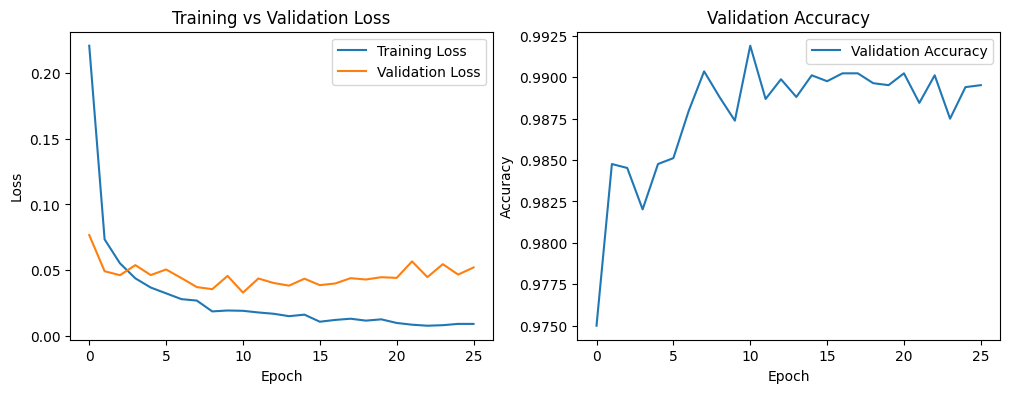

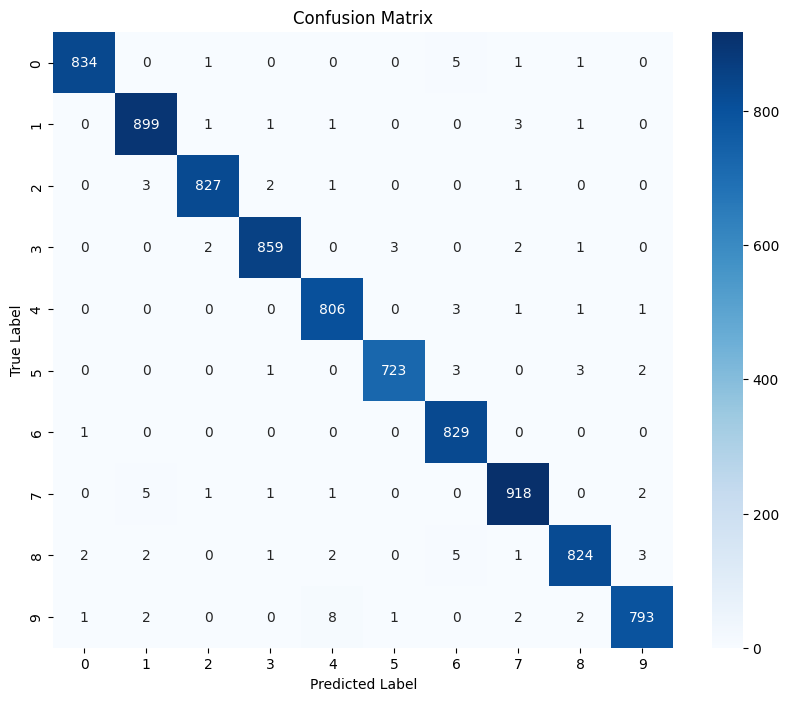

In [10]:
# Plot loss and accuracy (part of the Early stopping method to making sure we are not overfitting):

plt.figure(figsize=(12,4)) #Creates a 12x4 inch figure.

#left graph:
plt.subplot(1,2,1) #Divide the drawing into 1 row and 2 columns, and select the first graph (1).
#Draws two lines:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend() #Shows which curve is which
plt.title('Training vs Validation Loss')

#Right graph:
#Draws a graph of the accuracy along the epochs
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()#Shows which curve is which
plt.title('Validation Accuracy')
plt.show()

# Add a confusion matrix for error analysis:
model.eval()#Moves the model to evaluation mode
with torch.no_grad(): #No gradients
    predictions = model(x_val)
    _, predicted_classes = torch.max(predictions,1) #Find the digit with the highest score in each picture.

cm = confusion_matrix(y_val.numpy(), predicted_classes.numpy()) #Creates a 10×10 confusion matrix after validation.

#Drawing the confusion matrix (Helps you understand which digits the model struggles with (like 4 vs 9, or 3 vs 8):
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #Heatmap
plt.xlabel('Predicted Label') #What the model predicted
plt.ylabel('True Label')#What is the truth
plt.title('Confusion Matrix')
plt.show()

# Find most confused pairs
for i in range(10):
    for j in range(10):
        if i != j and cm[i][j] > 50: # Threshold for "many" mistakes
            print(f"Model often confuses {i} with {j}: {cm[i][j]} times")